### Install the necessary Libraries

In [1]:
pip install pydicom

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /opt/anaconda3/lib/python3.8/site-packages (0.11.1)
Note: you may need to restart the kernel to use updated packages.


### Import the Necessary Libraries

In [3]:
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pydicom as dcm
import os
from matplotlib.patches import Rectangle
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import tensorflow
from tensorflow.keras.layers import *
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Load Datasets

We observed that there are 3 dataset we have .
1. Label Data : where we have patient id and image bounding box coordinates and Target value
2. Class Data :  Where we have patient id and its class
3. Image Dataset in from of dicom images .

Let's try to read these data and get an overview

In [4]:
label_data = pd.read_csv("Data/stage_2_train_labels.csv")

In [5]:
label_data.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

We observed that the patient having no bounding box coordinates are labeled as Target 0 indicating that Target 0 is not phenumonia class

In [6]:
class_info = pd.read_csv("Data/stage_2_detailed_class_info.csv")

In [7]:
class_info.head(4)

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal

### Database table Preprocessing

Let's check for missing values

In [8]:
def check_for_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)   # total number of null values
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) #percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # putting the above two together
    return missing_data # return the dataframe

In [9]:
check_for_missing_data(label_data)

Total   Percent
height     20672  0.683892
width      20672  0.683892
y          20672  0.683892
x          20672  0.683892
Target         0  0.000000
patientId      0  0.000000

As mentioned earlier the missing value in coordinates indicates not phenumonia class

In [10]:
check_for_missing_data(class_info)

Total  Percent
class          0      0.0
patientId      0      0.0

No missing value found in the class_info table

All the target values are filled therefore there is no empty value, cell with Nan or empty cell are having no phenumonia so we should replace those value with 0

In [11]:
label_data.fillna(0, inplace=True)

In [12]:
label_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          30227 non-null  float64
 2   y          30227 non-null  float64
 3   width      30227 non-null  float64
 4   height     30227 non-null  float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


x, y, width, height are float type therefore we can say that they all have the numerical values

In [13]:
label_data[label_data["Target"]==1].describe().T

count        mean         std   min    25%    50%    75%    max
x       9555.0  394.047724  204.574172   2.0  207.0  324.0  594.0  835.0
y       9555.0  366.839560  148.940488   2.0  249.0  365.0  478.5  881.0
width   9555.0  218.471376   59.289475  40.0  177.0  217.0  259.0  528.0
height  9555.0  329.269702  157.750755  45.0  203.0  298.0  438.0  942.0
Target  9555.0    1.000000    0.000000   1.0    1.0    1.0    1.0    1.0

from here we can get an idea of mean width and mean height of the phenumoniatic image areas

In [14]:
np.unique(class_info["class"])

array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
      dtype=object)

We can divide the dataset in 3 classes 

1. confirmed phenumoia
2. partial phenumonia
3. Normal Lungs

In [15]:
np.unique(label_data["Target"])

array([0, 1])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


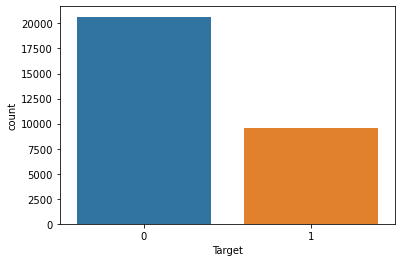

In [16]:
sns.countplot(label_data["Target"])

in label data we have more number of not phenumonia cases as compared to phenumonia cases

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


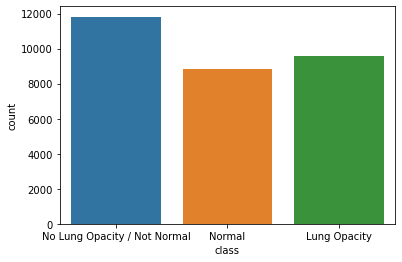

In [17]:
sns.countplot(class_info["class"])

From the class info we can say that we have 3 classes out of that 2 classes represent same category in label data therefore from the observation Not Normal and Normal class are categorized as 0 only when there is lung opacity it is classified as class 1. 

To confirm this let's view some data individually 

In [18]:
class_info[class_info["patientId"]=='0004cfab-14fd-4e49-80ba-63a80b6bddd6']

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal

In [19]:
label_data[label_data['patientId']=='0004cfab-14fd-4e49-80ba-63a80b6bddd6']

patientId    x    y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  0.0  0.0    0.0     0.0       0

No Lung Opacity / Not Normal has been classified as Target 0

In [20]:
class_info[class_info["patientId"]=='003d8fa0-6bf1-40ed-b54c-ac657f8495c5']

patientId   class
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  Normal

In [21]:
label_data[label_data['patientId']=='003d8fa0-6bf1-40ed-b54c-ac657f8495c5']

patientId    x    y  width  height  Target
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  0.0  0.0    0.0     0.0       0

Noraml has been classified as 0 too

In [22]:
class_info[class_info["patientId"]=='00436515-870c-4b36-a041-de91049b9ab4']

patientId         class
4  00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity
5  00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity

In [23]:
label_data[label_data['patientId']=='00436515-870c-4b36-a041-de91049b9ab4']

patientId      x      y  width  height  Target
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1

Lung Opacity has been classified as 1 and other classes has been classified as Normal indicated as 0

The class value 'No Lung Opacity / Not Normal ' is classified as 0 as it could be case of other complication which is not phenumonia

In [24]:
# Let's get the count of images we have for test and training
train_images_dir = 'Data/stage_2_train_images/'
train_images = [f for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))]
test_images_dir = 'Data/stage_2_test_images/'
test_images = [f for f in os.listdir(test_images_dir) if os.path.isfile(os.path.join(test_images_dir, f))]
print('5 Training images', train_images[:5]) # Print the first 5

5 Training images ['7be6b4de-afe9-43c0-a581-0f49608c8976.dcm', '2dcdd159-2889-48d3-a0ce-5c7b1086c49d.dcm', 'd8e66874-305e-4c80-9b75-5e764eb718ff.dcm', '22f2d3ec-f7ea-4778-850d-bb111590202f.dcm', 'cdaa07d4-4234-4cd2-b9bf-abbf5aed1bb4.dcm']


In [25]:
print('Number of train images:', len(train_images))
print('Number of test images:', len(test_images))

Number of train images: 26684
Number of test images: 3000


Let's see what kind of information a dicom file has

In [26]:
dicom_file_path = os.path.join("Data/stage_2_train_images/0b510189-2f09-4273-89fe-4ce4581ae69a.dcm")
file = dcm.read_file(dicom_file_path)
file

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.7608.1517874332.600508
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.7608.1517874332.600508
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

For detailed EDA let's take some important information from these files. 
1. Patient ID
2. Patient's Sex
3. Patient's Age 
4. View Position
5. Image Size

In [27]:
column_list = ["Patient ID", "Patient Sex", "Patient's Age", "View Position", "Image Size"]
file_meta_Data = pd.DataFrame(columns=column_list)

In [28]:
def add_meta_data_to_df(df, loc, from_list):
    data = []
    for filename in from_list:
            imagePath = loc+filename
            data_row_img_data = dcm.read_file(imagePath)
            values = []
            values.append(data_row_img_data.PatientID)
            values.append(data_row_img_data.PatientSex)
            values.append(data_row_img_data.PatientAge)
            values.append(data_row_img_data.ViewPosition)
            values.append(f"{data_row_img_data.Rows}x{data_row_img_data.Columns}")
            zipped_val = dict(zip(column_list, values))
            df = df.append(zipped_val, True)
    return df
    

In [29]:
file_meta_Data = add_meta_data_to_df(file_meta_Data, "Data/stage_2_train_images/", train_images)

In [30]:
file_meta_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Patient ID     26684 non-null  object
 1   Patient Sex    26684 non-null  object
 2   Patient's Age  26684 non-null  object
 3   View Position  26684 non-null  object
 4   Image Size     26684 non-null  object
dtypes: object(5)
memory usage: 1.0+ MB


In [31]:
np.unique(file_meta_Data['Image Size'])

array(['1024x1024'], dtype=object)

from the above image size we can say that we have images of all same sizes 1024x1024

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


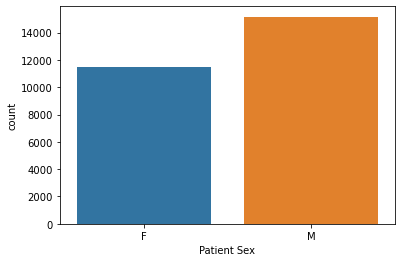

In [32]:
sns.countplot(file_meta_Data['Patient Sex'])

we have more samples taken from Male as compared to Females 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


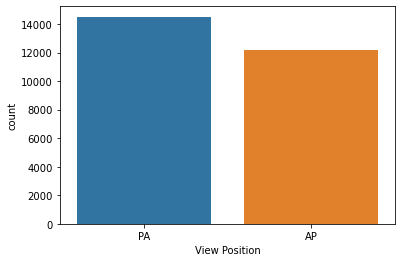

In [33]:
sns.countplot(file_meta_Data['View Position'])

We have 2 view positions in the images

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


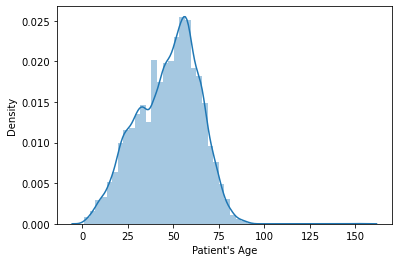

In [34]:
sns.distplot(file_meta_Data["Patient's Age"])

In [35]:
np.max(file_meta_Data["Patient's Age"])

'92'

In [36]:
np.min(file_meta_Data["Patient's Age"])

'1'

The patient age range from 1 to 92 whereas more samples has been taken from age range betweem  30 to 60

The above gives more information on the individual data, but in our modeling case these are not relevant 

### Data Visualisation 

In [37]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = f"Data/stage_2_train_images/{patientImage}"
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target']))
        rows = label_data[label_data['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()

In [38]:
def show_images(data):
    img_data = list(data.T.to_dict().values())
    
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = f"Data/stage_2_train_images/{patientImage}"
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

Let display some images that has been classified as a case of phenumonia

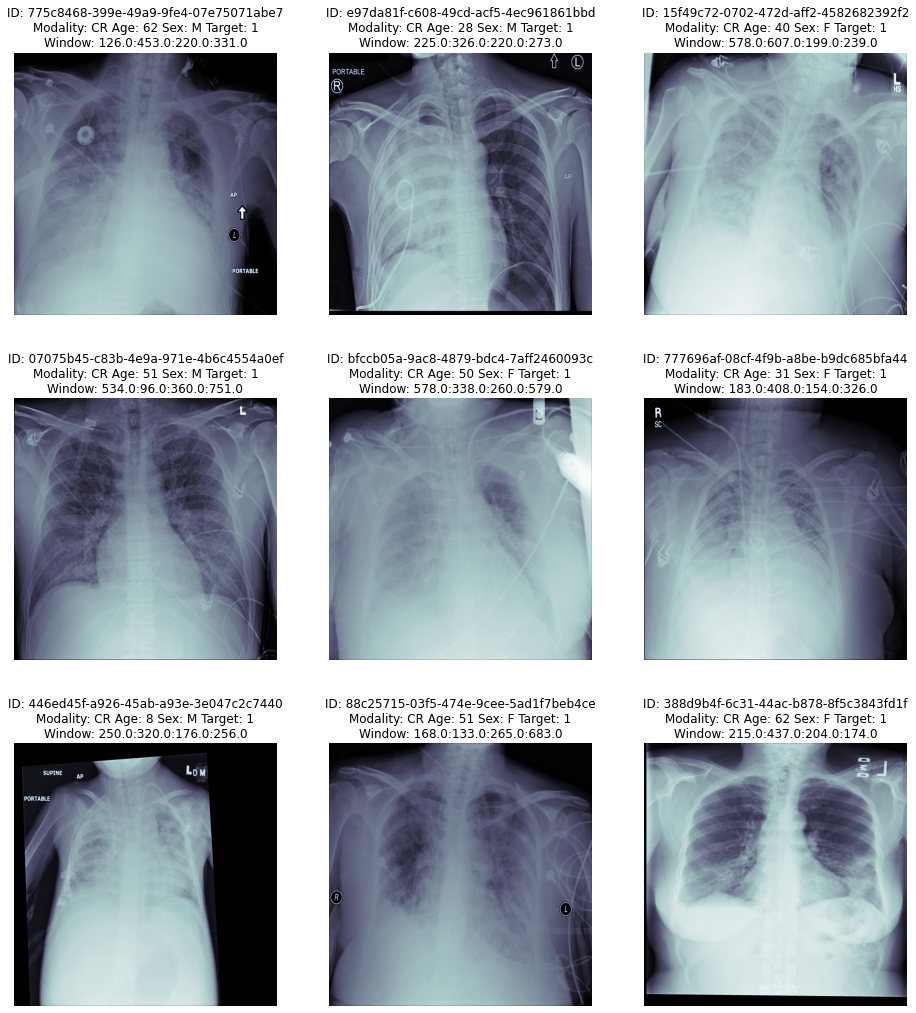

In [39]:
show_images(label_data[label_data['Target']==1].sample(9))

Also display the image of normal lungs so that we can have idea about how normal lungs will look

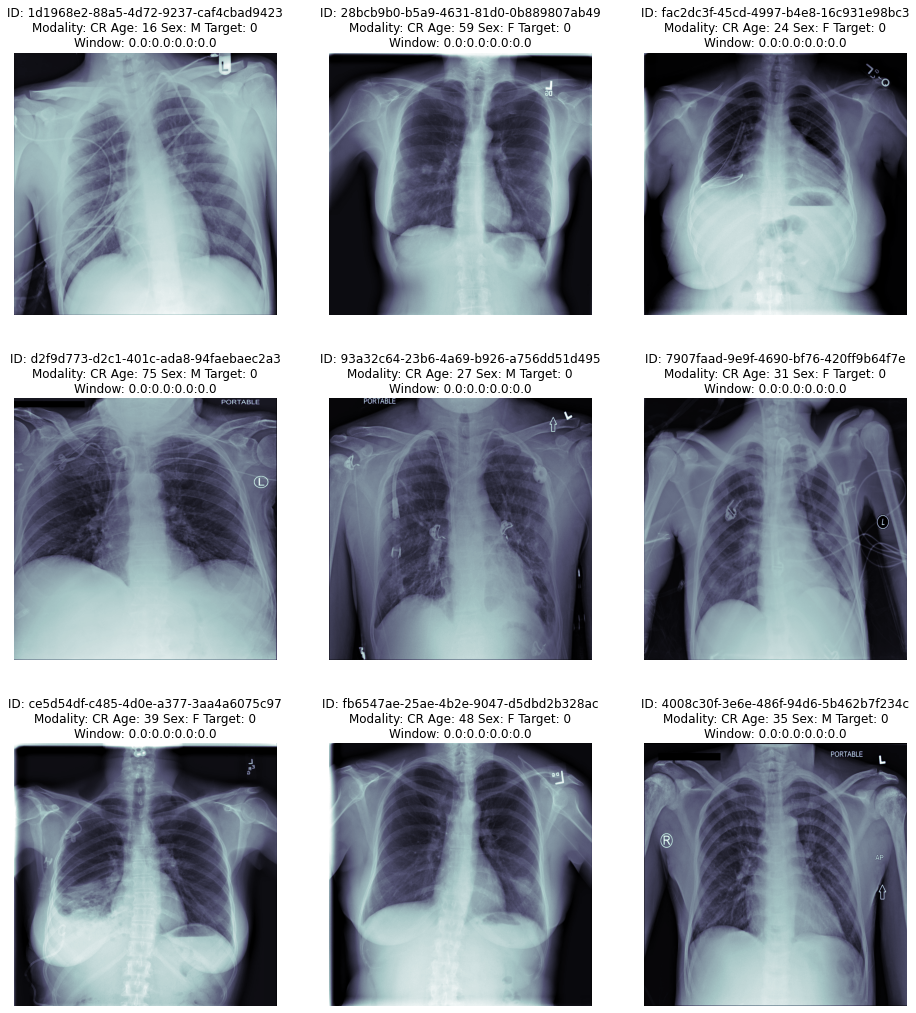

In [40]:
show_images(label_data[label_data['Target']==0].sample(9))

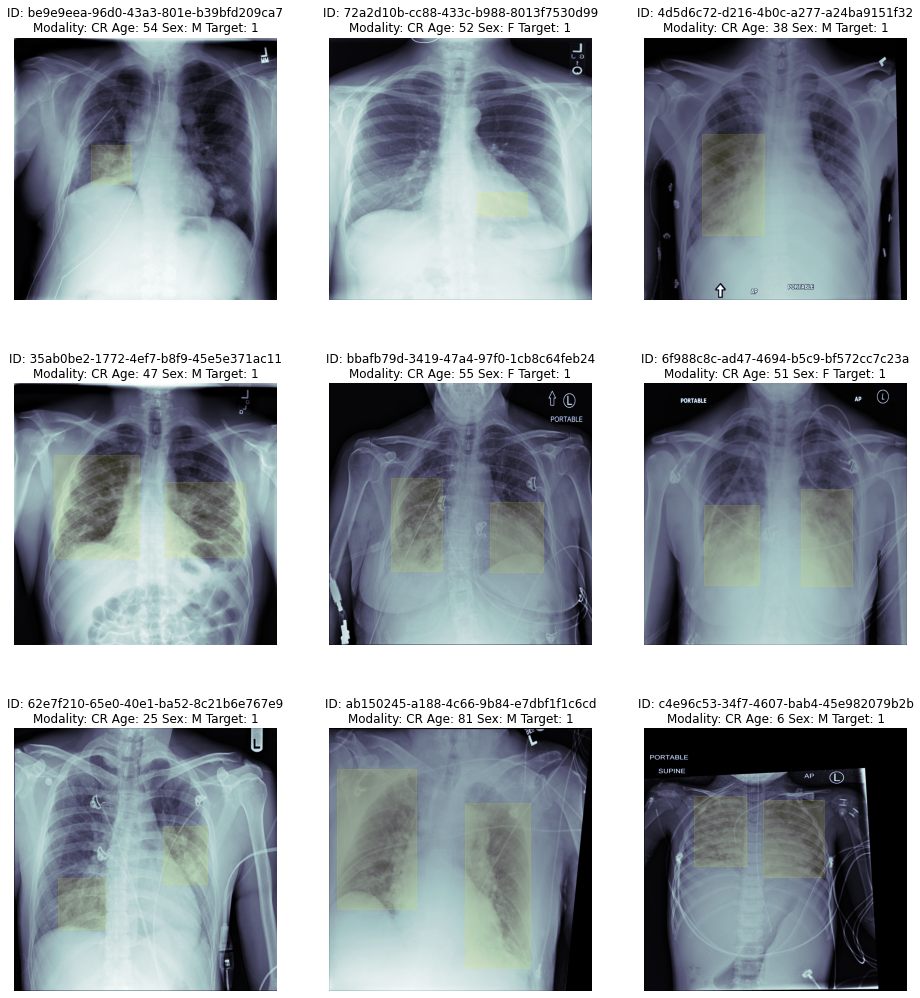

In [41]:
show_dicom_images_with_boxes(label_data[label_data['Target']==1].sample(9))

In [42]:
class_info.shape

(30227, 2)

In [43]:
class_info[class_info['patientId']=='00436515-870c-4b36-a041-de91049b9ab4']

patientId         class
4  00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity
5  00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity

In [44]:
class_info.drop_duplicates(subset='patientId', keep='last', inplace=True)

In [45]:
class_info.shape

(26684, 2)

In [46]:
IMAGE_SIZE = 1024
ADJUSTED_IMAGE_SIZE=224
MASK_IMAGE_SIZE = 28
FACTOR = MASK_IMAGE_SIZE/IMAGE_SIZE

In [47]:
class_info = shuffle(class_info)

In [48]:
#class_train, class_val = train_test_split(class_info, test_size=0.10, random_state=42, stratify=class_info['class'])

In [49]:
X_feature_tr = []
y_feature_target_tr = []
y_feature_coordinates_tr = []
from PIL import Image

### Data Preprocessing

Now let's create the mask images are per the given coordinates

In [50]:
def create_mask(datafm):
    X = []
    y=[]
    masks = np.zeros((int(datafm.shape[0]), MASK_IMAGE_SIZE, MASK_IMAGE_SIZE))
    for index, patient_id in enumerate(datafm['patientId'].T.to_dict().values()):
        image_path = train_images_dir+patient_id+".dcm"
        img = dcm.read_file(image_path)
        img = img.pixel_array
        img = cv2.resize(img, (ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        img = Image.fromarray(img)
        img = img.convert('RGB')
        img = np.array(img, dtype=np.float32)
        #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        #kernel = 1/3 * kernel
        #img = cv2.filter2D(img, -1, kernel)
        img = preprocess_input(img)
        X.append(img)
        rows = label_data[label_data['patientId']==patient_id]
        y.append(rows['Target'].values[0])

        row_data = list(rows.T.to_dict().values())
        for row in row_data:
            x1 = int(row['x']*FACTOR)
            x2 = int((row['x']*FACTOR)+(row['width']*FACTOR))
            y1 = int(row['y']*FACTOR)
            y2 = int((row['y']*FACTOR)+(row['height']*FACTOR))
            masks[index][y1:y2, x1:x2] = 1
            
    return X, y, masks

In [51]:
images, targets, masks = create_mask(class_info)

In [52]:
np.unique(targets, return_counts=True)

(array([0, 1]), array([20672,  6012]))

As we know from the above EDA that we have less number of phenumonia Cases that can bias our train model towards non phenumonia cases, 

Therefore it is required to up-sample the images for phenumonia cases along with it's mask

we will be performing following data augmentation for images and its mask.

1. Image Horizontal flip
2. Right shifting the image
3. Left shifting the image

In [53]:
def left_shift_image(img):
    height, width = img.shape[:2]
    scaled_height, scaled_width = height / 6, width / 6
    T = np.float32([[1, 0, -scaled_width], [0, 1, 0]])
    return cv2.warpAffine(img, T, (width, height))

In [54]:
def right_shift_image(img):
    height, width = img.shape[:2]
    scaled_height, scaled_width = height / 6, width / 6
    T = np.float32([[1, 0, scaled_width], [0, 1, 0]])
    return cv2.warpAffine(img, T, (width, height))

In [55]:
temp_images = images.copy()
temp_targets = targets.copy()
temp_masks = masks.copy()  

In [56]:
temp_masks = temp_masks.tolist()

In [57]:
def augment_data_horizontal_flip(image_list, target_list, mask_list):
    for i in range(len(image_list)):
        if target_list[i]==1:
            temp_images.append(cv2.flip(image_list[i], 1))
            temp_masks.append(cv2.flip(np.array(mask_list[i]), 1))
            temp_targets.append(target_list[i])

In [58]:
def augment_data_right_shift(image_list, target_list, mask_list):
    for i in range(len(image_list)):
        if target_list[i]==1:
            temp_images.append(right_shift_image(image_list[i]))
            temp_masks.append(right_shift_image(np.array(mask_list[i])))
            temp_targets.append(target_list[i])

In [59]:
def augment_data_left_shift(image_list, target_list, mask_list):
    for i in range(len(image_list)):
        if target_list[i]==1:
            temp_images.append(left_shift_image(image_list[i]))
            temp_masks.append(left_shift_image(np.array(mask_list[i])))
            temp_targets.append(target_list[i])

In [60]:
augment_data_horizontal_flip(images, targets, masks)
augment_data_right_shift(images, targets, masks)
augment_data_left_shift(images, targets, masks)

In [61]:
np.array(temp_images).shape

(44720, 224, 224, 3)

In [62]:
np.unique(temp_targets, return_counts=True)

(array([0, 1]), array([20672, 24048]))

We have successfully upsampled the Phenumonia cases in Data

In [63]:
temp_images = np.array(temp_images)
temp_masks = np.array(temp_masks)
temp_targets = np.array(temp_targets)

### Test and train split at close to 4:1 ratio after shuffling the data

In [64]:
indices = np.arange(temp_targets.shape[0])
np.random.shuffle(indices)

images = temp_images[indices]
masks = temp_masks[indices]
targets = temp_targets[indices]

In [65]:
images.shape

(44720, 224, 224, 3)

In [66]:
masks.shape

(44720, 28, 28)

In [67]:
targets.shape

(44720,)

In [68]:
X_train = images[0:35000]
y_train = masks[0:35000]
y_target_tr = targets[0:35000]

X_test = images[35000:]
y_test = masks[35000:]
y_target_test = targets[35000:]

In [69]:
X_train.shape

(35000, 224, 224, 3)

In [70]:
X_test.shape

(9720, 224, 224, 3)

### Model Creation Test 1 : Unet

In [71]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model, load_model

In [72]:
ALPHA = 1

In [73]:
#this function will creat U-net model
def create_model(trainable=True):
    model = MobileNet(input_shape=(224, 224, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((28, 28))(x)

    return Model(inputs=model.input, outputs=x)

In [74]:
model = create_model(False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

In [75]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

In [76]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [77]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-2, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [78]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=4)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.02, patience=2, min_lr=1e-6, verbose=1)

In [79]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=10, batch_size=12, verbose=1, callbacks=[checkpoint, stop, reduce_lr])

Epoch 1/10
2917/2917 [==============================] - 1147s 393ms/step - loss: 1.1816 - dice_coefficient: 0.4562 - val_loss: 1.3038 - val_dice_coefficient: 0.4685

Epoch 00001: val_loss improved from inf to 1.30384, saving model to model-1.30.h5
Epoch 2/10
2917/2917 [==============================] - 1124s 385ms/step - loss: 1.0673 - dice_coefficient: 0.4991 - val_loss: 1.1038 - val_dice_coefficient: 0.5149

Epoch 00002: val_loss improved from 1.30384 to 1.10376, saving model to model-1.10.h5
Epoch 3/10
2917/2917 [==============================] - 1142s 392ms/step - loss: 1.1054 - dice_coefficient: 0.4977 - val_loss: 1.0582 - val_dice_coefficient: 0.5217

Epoch 00003: val_loss improved from 1.10376 to 1.05818, saving model to model-1.06.h5
Epoch 4/10
2917/2917 [==============================] - 1169s 401ms/step - loss: 1.1111 - dice_coefficient: 0.4966 - val_loss: 1.1032 - val_dice_coefficient: 0.5174

Epoch 00004: val_loss did not improve from 1.05818
Epoch 5/10
2917/2917 [=========

Let's save the model, we already have the saved weights of the model

In [81]:
model.save("unet_ph.h5")

### Load the saved model

We wil be loading model-0.93.h5 as it has better dice coefficient for both test and train data and least validation loss

In [82]:
from tensorflow.keras.models import load_model

In [83]:
final_model = load_model("unet_ph.h5", compile=False)
final_model.load_weights("model-0.93.h5")

Now the model is trained let's predict some values and mask, we will needs these value for SVM classifier to find if the predicted mask should be categorised as phenumonia case or not

In [153]:
mask_predicated_test = 1.0*(final_model.predict(X_test)>0.6)

In [154]:
mask_predicated_train = 1.0*(final_model.predict(X_train)>0.6)

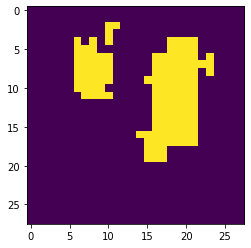

In [155]:
plt.imshow(mask_predicated_train[19])

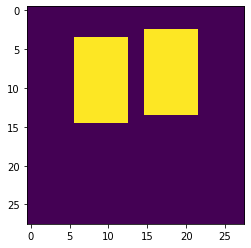

In [94]:
plt.imshow(y_train[19])

In [156]:
X_train_svm = y_train.reshape(y_train.shape[0], -1)
X_test_svm = y_test.reshape(y_test.shape[0], -1)
mask_predicated_train_svm = mask_predicated_train.reshape(mask_predicated_train.shape[0], -1)
mask_predicated_test_svm = mask_predicated_test.reshape(mask_predicated_test.shape[0], -1)

In [106]:
from sklearn import svm
svc_clf = svm.SVC(kernel='rbf', gamma=0.01, probability=True)
svc_clf.fit(X_train_svm, y_target_tr)

svc_clf.score(X_test_svm, y_target_test)

0.9984567901234568

In [107]:
svc_clf.score(X_train_svm, y_target_tr)

0.9984285714285714

In [157]:
svc_clf.score(mask_predicated_test_svm, y_target_test)

0.809156378600823

In [158]:
svc_clf.score(mask_predicated_train_svm, y_target_tr)

0.8024285714285714

Therefore we can say that our model is giving 80% accuracy, let save this SVM model

In [159]:
test_results = svc_clf.predict(mask_predicated_test_svm)

In [160]:
train_results = svc_clf.predict(mask_predicated_train_svm)

In [110]:
import pickle

In [111]:
filename = 'Unet_Support_model.sav'
pickle.dump(svc_clf, open(filename, 'wb'))

fianlly we can say that there are 2 models , 1 models predicts the mask from the given image and 2nd model decides if the mask should be considered as phenumonia or not

In [118]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix


def printConfusionMatrix(title, y_true, y_pred):
    print (title)
    print ('-------------------')
    print ('Validation Accuracy: ', accuracy_score(y_true,y_pred))
    print ('Validation Precision: ', precision_score(y_true,y_pred))
    print ('Validation Recall: ', recall_score(y_true,y_pred))
    print ('Validation F1-Score: ', f1_score(y_true,y_pred))
    
    cm=confusion_matrix(y_true, y_pred, labels=[1, 0])
    df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                      columns = [i for i in ["Predict Yes","Predict No"]])
    #Plot the heat map for the confusion matrix
    plt.figure(figsize = (5,5))   
    sns.heatmap(df_cm, annot=True, fmt="g", yticklabels=["Actual Yes", "Actual No"], cmap="YlGnBu_r")
    ax = plt.gca()
    ax.set_title(title)    
    plt.show()
    return accuracy_score(y_true,y_pred), precision_score(y_true,y_pred),recall_score(y_true,y_pred),f1_score(y_true,y_pred)

Train Confusion matrix
-------------------
Validation Accuracy:  0.8024285714285714
Validation Precision:  0.7558214608530969
Validation Recall:  0.9339431975321775
Validation F1-Score:  0.8354942309979778


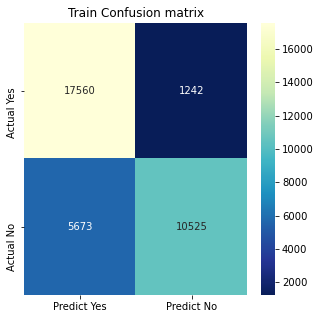

(0.8024285714285714,
 0.7558214608530969,
 0.9339431975321775,
 0.8354942309979778)

In [161]:
printConfusionMatrix("Train Confusion matrix", y_target_tr, train_results)

Test Confusion matrix
-------------------
Validation Accuracy:  0.809156378600823
Validation Precision:  0.7633990989591425
Validation Recall:  0.936713686618376
Validation F1-Score:  0.8412222887956861


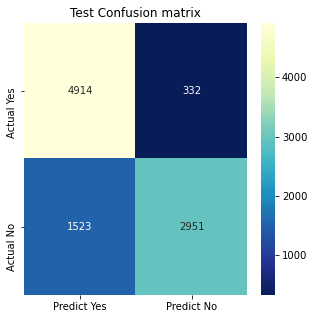

(0.809156378600823, 0.7633990989591425, 0.936713686618376, 0.8412222887956861)

In [162]:
printConfusionMatrix("Test Confusion matrix", y_target_test, test_results)

from the above results we can say the our model performs decent , but not that great , but still it is able to mimimize Type 1 error which is important in medical terms